Purpose of this notebook is to quickly look at the data then apply various cleaning operations

**Imports**

In [1]:

import os

import numpy as np

import pandas as pd

import pyplotterlib.standard.plotters as ppl

import shared_code_path
import proc_pipes as procPipeHelp
import train_pipes as trainPipeHelp

2023-04-22 15:04:54.438047: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-22 15:04:54.439312: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-22 15:04:54.462776: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-22 15:04:54.463223: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-22 15:04:54.843760: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

**Configuration Variables**

In [2]:
TRAIN_PATH = os.path.abspath( os.path.join("..","..","..","raw_data","train.csv") )
EMBEDDING_PATH = os.path.join("..","..","..","raw_data","glove.twitter.27B.25d.txt")

**Import the raw training data**

In [3]:
RAW_TRAIN = pd.read_csv(TRAIN_PATH)
RAW_TRAIN.head(2)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1


**Check for NaN across columns**

In [4]:
RAW_TRAIN.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

**Print various information about the data**

In [5]:
_numbEntries = len(RAW_TRAIN)
_uniqueTargVals = RAW_TRAIN["target"].unique()
_fractDisasterTweets = len( RAW_TRAIN.loc[ RAW_TRAIN["target"]==1 ] ) / _numbEntries
_fractOtherTweets = len( RAW_TRAIN.loc[ RAW_TRAIN["target"]==0 ] ) / _numbEntries

#
_numbUniqueKeywords = len(RAW_TRAIN["keyword"].unique())
_numbUniqueLocations = len(RAW_TRAIN["location"].unique())
_maxTextLength = RAW_TRAIN["text"].map(lambda x:len(x)).max()
_minTextLength = RAW_TRAIN["text"].map(lambda x:len(x)).min()

#Target info
print("Total of {} entries".format(_numbEntries))
print("Unique values of the target = {}".format(_uniqueTargVals))
print("{:.1f}% Disaster tweets; {:.1f}% other tweets".format( 100*_fractDisasterTweets, 100*_fractOtherTweets ) )

#Other info
print("")
print("{} unique keywords; {} unique locations".format(_numbUniqueKeywords, _numbUniqueLocations))
print("Maximum of {} characters in the text field".format(_maxTextLength))
print("Minimum of {} characters in the text field".format(_minTextLength))

Total of 7613 entries
Unique values of the target = [1 0]
43.0% Disaster tweets; 57.0% other tweets

222 unique keywords; 3342 unique locations
Maximum of 157 characters in the text field
Minimum of 7 characters in the text field


**Import the embedding vectors into a dictionary**

In [6]:
def getGloveVectors(inpPath):
    outDict = dict()
    with open(inpPath,"rt") as f:
        for line in f:
            splitLine = line.split()
            outDict[splitLine[0]] = np.array(splitLine[1:],dtype='float64')
    return outDict

In [7]:
%%prun
#2449954 function calls in 3.795 seconds
EMBED_DICT = getGloveVectors(EMBEDDING_PATH)

Print out an entry from the embedding dict

In [8]:
_nthEntry = 15
_tempIter = iter(EMBED_DICT.items())
for n in range(_nthEntry):
    next(_tempIter)
next(_tempIter)

('you',
 array([-0.41586 ,  0.32548 , -0.087621,  0.2018  , -0.80017 , -0.34418 ,
         2.1431  ,  0.37188 , -0.9409  ,  0.24283 , -0.86396 ,  0.63858 ,
        -6.0171  , -0.54081 , -0.43305 ,  0.095707,  0.37971 , -1.1432  ,
         0.11382 , -0.38361 ,  0.41758 ,  0.081476, -0.02659 ,  0.75438 ,
        -0.77178 ]))

**Convert all our tweets to lowercase; since thats whats in the GloVe dictionary**

In [9]:
PROC_DATA = procPipeHelp.ConvertToLowerCase().transform(RAW_TRAIN)

**Create functions to help show how many/which words are in/out of our vocabulary**

In [10]:
def getWordsCountsDict(inpText):
    countDict = dict()
    for currStr in inpText:
        splitStr = currStr.split()
        for token in splitStr:
            try:
                countDict[token] += 1
            except KeyError:
                countDict[token] = 1
    return countDict


def printFractionWordsInVocab(countDict):
    inVocab, outOfVocab = getWordsInAndOutOfVocab(countDict, EMBED_DICT)
    
    #
    _totalWords = sum(countDict.values())
    _inVocab, _oov = sum(inVocab.values()), sum(outOfVocab.values())
    
    percIn, percOut = 100*(_inVocab / _totalWords), 100*(_oov / _totalWords)
    print("{:.2f} % of words in vocabulary".format( percIn ))
    print("{:.2f} % of words out of vocabulary".format( percOut ))
    return percIn, percOut

def getWordsInAndOutOfVocab(countDict, embedDict):
    inDict, outDict = dict(), dict()
    for key in countDict.keys():
        try:
            embedDict[key]
        except KeyError:
            outDict[key] = countDict[key]
        else:
            inDict[key] = countDict[key]
            
    return inDict, outDict


**Create a list to show track how each cleaning operation increases % words in our vocab**

In [11]:
#Each entry will be [ description of thingy, Percentage of words in the vocab ]
IN_VOCAB_VALUES = list()

**Look at how many words are in GloVe embeddings dict pre-cleaning**

In [12]:
_countDict = getWordsCountsDict(PROC_DATA["text"])
_inVocab, _outOfVocab = getWordsInAndOutOfVocab(_countDict,EMBED_DICT)

_percIn, _percOut = printFractionWordsInVocab(_countDict)

IN_VOCAB_VALUES.append( ["Start",_percIn]   )


77.59 % of words in vocabulary
22.41 % of words out of vocabulary


Also look at the most common "words" which are missing from our vocabulary

In [13]:
sorted(_outOfVocab.items(), key=lambda x:x[1], reverse=True)

[("i'm", 237),
 ('??', 214),
 ("it's", 176),
 ("don't", 168),
 ('...', 147),
 ('2', 145),
 ('????', 96),
 ("can't", 86),
 ('@youtube', 83),
 ('3', 81),
 ("you're", 66),
 ('5', 56),
 ('??????', 55),
 ('4', 55),
 ("that's", 51),
 ('\x89û_', 50),
 ("i've", 40),
 ('70', 40),
 ('1', 39),
 ("he's", 39),
 ('mh370:', 39),
 ('\x89ûò', 38),
 ("there's", 37),
 ("i'll", 34),
 ('40', 32),
 ("'the", 32),
 ('2015', 31),
 ('15', 31),
 ("legionnaires'", 31),
 ('latest:', 31),
 ('#prebreak', 30),
 ('bioterror', 29),
 ('video:', 28),
 ('16yr', 28),
 ('a...', 27),
 ('re\x89û_', 27),
 ('6', 27),
 ('\x89ûó', 26),
 ("i'd", 26),
 ('8', 26),
 ('w/', 26),
 ("what's", 25),
 ("doesn't", 25),
 ('typhoon-devastated', 25),
 ('legionnaires:', 25),
 ("'conclusively", 25),
 ("confirmed'", 25),
 ("didn't", 24),
 ('pm:', 24),
 ('crash:', 24),
 ('#???', 23),
 ('fire.', 22),
 ('saipan:', 22),
 ('30', 21),
 ("we're", 21),
 ('.:', 21),
 ('#hiroshima', 21),
 ('derailment:', 21),
 ('11-year-old', 21),
 ("they're", 20),
 ('#??'

**Deal with the contractions (e.g. we're to we are)**

In [14]:
PROC_DATA = procPipeHelp.ReplaceContractions().transform(PROC_DATA)

_countDict = getWordsCountsDict(PROC_DATA["text"])
_inVocab, _outOfVocab = getWordsInAndOutOfVocab(_countDict,EMBED_DICT)

_percIn, _percOut = printFractionWordsInVocab(_countDict)

IN_VOCAB_VALUES.append( ["Contractions",_percIn]   )


78.99 % of words in vocabulary
21.01 % of words out of vocabulary


In [15]:
sorted(_outOfVocab.items(), key=lambda x:x[1], reverse=True)

[('??', 214),
 ('...', 147),
 ('2', 145),
 ('????', 96),
 ('@youtube', 83),
 ('3', 81),
 ('5', 56),
 ('??????', 55),
 ('4', 55),
 ('\x89û_', 50),
 ('70', 40),
 ('1', 39),
 ('mh370:', 39),
 ('\x89ûò', 38),
 ('40', 32),
 ("'the", 32),
 ('2015', 31),
 ('15', 31),
 ("legionnaires'", 31),
 ('latest:', 31),
 ('#prebreak', 30),
 ('bioterror', 29),
 ('video:', 28),
 ('16yr', 28),
 ('a...', 27),
 ('re\x89û_', 27),
 ('6', 27),
 ('\x89ûó', 26),
 ("'i", 26),
 ('8', 26),
 ('w/', 26),
 ("'we", 25),
 ('typhoon-devastated', 25),
 ('legionnaires:', 25),
 ("'conclusively", 25),
 ("confirmed'", 25),
 ('pm:', 24),
 ('crash:', 24),
 ('#???', 23),
 ('fire.', 22),
 ('saipan:', 22),
 ('30', 21),
 ('.:', 21),
 ('#hiroshima', 21),
 ('derailment:', 21),
 ('11-year-old', 21),
 ('#??', 20),
 ('update:', 20),
 ('mh370', 20),
 ('(detonation)', 20),
 ('were...', 20),
 ('#earthquake', 19),
 ('11', 19),
 ('photo:', 19),
 ('7', 19),
 ('soudelor', 19),
 ('disea...', 19),
 ('50', 18),
 ('bioterrorism', 18),
 ('????????', 

**Replace repeated punctuation (e.g ??? to ?)**

In [16]:
PROC_DATA =  procPipeHelp.ReplaceRepeatedPunctuation().transform(PROC_DATA)

_countDict = getWordsCountsDict(PROC_DATA["text"])
_inVocab, _outOfVocab = getWordsInAndOutOfVocab(_countDict,EMBED_DICT)

_percIn, _percOut = printFractionWordsInVocab(_countDict)

IN_VOCAB_VALUES.append( ["Repeated Punct.",_percIn]   )


79.67 % of words in vocabulary
20.33 % of words out of vocabulary


In [17]:
sorted(_outOfVocab.items(), key=lambda x:x[1], reverse=True)

[('2', 145),
 ('@youtube', 83),
 ('3', 81),
 ('5', 56),
 ('4', 55),
 ('\x89û_', 50),
 ('#?', 50),
 ('70', 40),
 ('1', 39),
 ('mh370:', 39),
 ('\x89ûò', 38),
 ('40', 32),
 ("'the", 32),
 ('2015', 31),
 ('15', 31),
 ("legionnaires'", 31),
 ('latest:', 31),
 ('#prebreak', 30),
 ('bioterror', 29),
 ('video:', 28),
 ('16yr', 28),
 ('re\x89û_', 27),
 ('6', 27),
 ('\x89ûó', 26),
 ("'i", 26),
 ('8', 26),
 ('w/', 26),
 ("'we", 25),
 ('typhoon-devastated', 25),
 ('legionnaires:', 25),
 ("'conclusively", 25),
 ("confirmed'", 25),
 ('pm:', 24),
 ('crash:', 24),
 ('fire.', 22),
 ('saipan:', 22),
 ('30', 21),
 ('.:', 21),
 ('#hiroshima', 21),
 ('derailment:', 21),
 ('11-year-old', 21),
 ('update:', 20),
 ('mh370', 20),
 ('(detonation)', 20),
 ('were.', 20),
 ('#earthquake', 19),
 ('11', 19),
 ('photo:', 19),
 ('7', 19),
 ('soudelor', 19),
 ('disea.', 19),
 ('50', 18),
 ('bioterrorism', 18),
 ("'it", 18),
 ('news!', 18),
 ('#islam', 18),
 ('bestnaijamade', 18),
 ('fires.', 17),
 ('news:', 17),
 ('#gb

**Replace single digit numbers with their text counterpart (e.g. "1" to "one")**

In [18]:
PROC_DATA = procPipeHelp.MapSingleDigitNumbersToWords().transform(PROC_DATA)


_countDict = getWordsCountsDict(PROC_DATA["text"])
_inVocab, _outOfVocab = getWordsInAndOutOfVocab(_countDict,EMBED_DICT)

_percIn, _percOut = printFractionWordsInVocab(_countDict)

IN_VOCAB_VALUES.append( ["Numbers to text",_percIn]   )


80.02 % of words in vocabulary
19.98 % of words out of vocabulary


In [19]:
sorted(_outOfVocab.items(), key=lambda x:x[1], reverse=True)

[('@youtube', 83),
 ('\x89û_', 50),
 ('#?', 50),
 ('70', 40),
 ('mh370:', 39),
 ('\x89ûò', 38),
 ('40', 32),
 ("'the", 32),
 ('2015', 31),
 ('15', 31),
 ("legionnaires'", 31),
 ('latest:', 31),
 ('#prebreak', 30),
 ('bioterror', 29),
 ('video:', 28),
 ('16yr', 28),
 ('re\x89û_', 27),
 ('\x89ûó', 26),
 ("'i", 26),
 ('w/', 26),
 ("'we", 25),
 ('typhoon-devastated', 25),
 ('legionnaires:', 25),
 ("'conclusively", 25),
 ("confirmed'", 25),
 ('pm:', 24),
 ('crash:', 24),
 ('fire.', 22),
 ('saipan:', 22),
 ('30', 21),
 ('.:', 21),
 ('#hiroshima', 21),
 ('derailment:', 21),
 ('11-year-old', 21),
 ('update:', 20),
 ('mh370', 20),
 ('(detonation)', 20),
 ('were.', 20),
 ('#earthquake', 19),
 ('11', 19),
 ('photo:', 19),
 ('soudelor', 19),
 ('disea.', 19),
 ('50', 18),
 ('bioterrorism', 18),
 ("'it", 18),
 ('news!', 18),
 ('#islam', 18),
 ('bestnaijamade', 18),
 ('fires.', 17),
 ('news:', 17),
 ('#gbbo', 17),
 ('funtenna:', 17),
 ('[black', 17),
 ('2015]', 17),
 (':)', 16),
 ('10', 16),
 ('70th'

**Remove hyperlinks**

In [20]:
PROC_DATA = procPipeHelp.ReplaceHyperlinks(replacement=" ").transform(PROC_DATA)


_countDict = getWordsCountsDict(PROC_DATA["text"])
_inVocab, _outOfVocab = getWordsInAndOutOfVocab(_countDict,EMBED_DICT)

_percIn, _percOut = printFractionWordsInVocab(_countDict)

IN_VOCAB_VALUES.append( ["Remove Hyperlinks",_percIn]   )


83.44 % of words in vocabulary
16.56 % of words out of vocabulary


In [21]:
sorted(_outOfVocab.items(), key=lambda x:x[1], reverse=True)

[('@youtube', 83),
 ('\x89û_', 54),
 ('#?', 50),
 ('70', 40),
 ('mh370:', 39),
 ('\x89ûò', 38),
 ('40', 32),
 ("'the", 32),
 ('2015', 31),
 ('15', 31),
 ("legionnaires'", 31),
 ('latest:', 31),
 ('#prebreak', 30),
 ('bioterror', 29),
 ('video:', 28),
 ('16yr', 28),
 ('re\x89û_', 27),
 ('\x89ûó', 26),
 ("'i", 26),
 ('w/', 26),
 ("'we", 25),
 ('typhoon-devastated', 25),
 ('legionnaires:', 25),
 ("'conclusively", 25),
 ("confirmed'", 25),
 ('pm:', 24),
 ('crash:', 24),
 ('fire.', 22),
 ('saipan:', 22),
 ('30', 21),
 ('.:', 21),
 ('#hiroshima', 21),
 ('derailment:', 21),
 ('11-year-old', 21),
 ('update:', 20),
 ('mh370', 20),
 ('(detonation)', 20),
 ('were.', 20),
 ('#earthquake', 19),
 ('11', 19),
 ('photo:', 19),
 ('soudelor', 19),
 ('disea.', 19),
 ('50', 18),
 ('bioterrorism', 18),
 ("'it", 18),
 ('news!', 18),
 ('#islam', 18),
 ('bestnaijamade', 18),
 ('fires.', 17),
 ('news:', 17),
 ('#gbbo', 17),
 ('funtenna:', 17),
 ('[black', 17),
 ('2015]', 17),
 (':)', 16),
 ('10', 16),
 ('70th'

**Replace some html characters**

In [22]:
print( procPipeHelp.ReplaceSpecialHTMLStrings().mapDict )

PROC_DATA = procPipeHelp.ReplaceSpecialHTMLStrings().transform(PROC_DATA)

_countDict = getWordsCountsDict(PROC_DATA["text"])
_inVocab, _outOfVocab = getWordsInAndOutOfVocab(_countDict,EMBED_DICT)

_percIn, _percOut = printFractionWordsInVocab(_countDict)

IN_VOCAB_VALUES.append( ["Replace HTML chars",_percIn]   )


{'&amp;': '&', '&gt;': '>', '&lt;': '<'}
83.47 % of words in vocabulary
16.53 % of words out of vocabulary


In [23]:
sorted(_outOfVocab.items(), key=lambda x:x[1], reverse=True)

[('@youtube', 83),
 ('\x89û_', 54),
 ('#?', 50),
 ('70', 40),
 ('mh370:', 39),
 ('\x89ûò', 38),
 ('40', 32),
 ("'the", 32),
 ('2015', 31),
 ('15', 31),
 ("legionnaires'", 31),
 ('latest:', 31),
 ('#prebreak', 30),
 ('bioterror', 29),
 ('video:', 28),
 ('16yr', 28),
 ('re\x89û_', 27),
 ('\x89ûó', 26),
 ("'i", 26),
 ('w/', 26),
 ("'we", 25),
 ('typhoon-devastated', 25),
 ('legionnaires:', 25),
 ("'conclusively", 25),
 ("confirmed'", 25),
 ('pm:', 24),
 ('crash:', 24),
 ('fire.', 22),
 ('saipan:', 22),
 ('30', 21),
 ('.:', 21),
 ('#hiroshima', 21),
 ('derailment:', 21),
 ('11-year-old', 21),
 ('update:', 20),
 ('mh370', 20),
 ('(detonation)', 20),
 ('were.', 20),
 ('#earthquake', 19),
 ('11', 19),
 ('photo:', 19),
 ('soudelor', 19),
 ('disea.', 19),
 ('50', 18),
 ('bioterrorism', 18),
 ("'it", 18),
 ('news!', 18),
 ('#islam', 18),
 ('bestnaijamade', 18),
 ('fires.', 17),
 ('news:', 17),
 ('#gbbo', 17),
 ('funtenna:', 17),
 ('[black', 17),
 ('2015]', 17),
 (':)', 16),
 ('10', 16),
 ('70th'

**Remove trailing punctuation**

In [24]:
PROC_DATA = procPipeHelp.RemoveTrailingPunctuation().transform(PROC_DATA)

_countDict = getWordsCountsDict(PROC_DATA["text"])
_inVocab, _outOfVocab = getWordsInAndOutOfVocab(_countDict,EMBED_DICT)

_percIn, _percOut = printFractionWordsInVocab(_countDict)

IN_VOCAB_VALUES.append( ["Remove Trailing Punctuation",_percIn]   )


89.17 % of words in vocabulary
10.83 % of words out of vocabulary


In [25]:
sorted(_outOfVocab.items(), key=lambda x:x[1], reverse=True)

[('@youtube', 83),
 (".'", 81),
 ('mh370', 64),
 ('\x89û_', 55),
 ('.s', 50),
 ('#?', 50),
 ('70', 42),
 ('2015', 41),
 ('1', 40),
 ('\x89ûò', 39),
 ('2', 38),
 ('10', 37),
 ('15', 36),
 ("'the", 34),
 ('40', 32),
 ("'.", 30),
 ('#prebreak', 30),
 ('bioterror', 29),
 ('11', 28),
 ('16yr', 28),
 ("'i", 27),
 ('.:', 27),
 ('re\x89û_', 27),
 ('4', 27),
 ('\x89ûó', 26),
 ("'t", 26),
 ('w/', 26),
 ("'we", 25),
 ('5', 25),
 ('typhoon-devastated', 25),
 ("'conclusively", 25),
 ('soudelor', 24),
 (':00', 23),
 ('#islam', 23),
 ('30', 22),
 ("':", 22),
 ("!'", 21),
 ('bioterrorism', 21),
 ('#hiroshima', 21),
 ('11-year-old', 21),
 ('12', 20),
 ('50', 20),
 ('3', 20),
 ('(detonation)', 20),
 ('#earthquake', 19),
 ('.o', 19),
 ('disea', 19),
 ('20', 18),
 ('05', 18),
 ('.p', 18),
 ("'it", 18),
 ('bestnaijamade', 18),
 ("?'", 17),
 ('16', 17),
 ('60', 17),
 ('#gbbo', 17),
 ('25', 17),
 ('funtenna', 17),
 ('[black', 17),
 ('2015]', 17),
 ('13', 16),
 (':)', 16),
 ('70th', 16),
 ('.i', 15),
 ('17', 

**Remove leading punctuation**

In [26]:
PROC_DATA = procPipeHelp.RemoveLeadingPunctuation().transform(PROC_DATA)

_countDict = getWordsCountsDict(PROC_DATA["text"])
_inVocab, _outOfVocab = getWordsInAndOutOfVocab(_countDict,EMBED_DICT)

_percIn, _percOut = printFractionWordsInVocab(_countDict)

IN_VOCAB_VALUES.append( ["Remove Leading Punctuation",_percIn]   )


90.14 % of words in vocabulary
9.86 % of words out of vocabulary


In [27]:
sorted(_outOfVocab.items(), key=lambda x:x[1], reverse=True)

[('@youtube', 83),
 (".'", 82),
 ('mh370', 64),
 ('\x89û_', 55),
 ('#?', 53),
 ('2', 48),
 ('1', 47),
 ('2015', 42),
 ('70', 42),
 ('15', 42),
 ('\x89ûò', 39),
 ('10', 38),
 ('30', 36),
 ('11', 36),
 ('40', 36),
 ('4', 34),
 ('00', 33),
 ("'.", 31),
 ('5', 31),
 ('#prebreak', 30),
 ('bioterror', 29),
 ('16yr', 28),
 ('.:', 27),
 ('re\x89û_', 27),
 ('\x89ûó', 26),
 ('3', 26),
 ('w/', 26),
 ('25', 25),
 ('typhoon-devastated', 25),
 ('soudelor', 24),
 ('#islam', 23),
 ('9', 22),
 ('16', 22),
 ("':", 22),
 ('50', 22),
 ('01', 22),
 ('20', 21),
 ("!'", 21),
 ('bioterrorism', 21),
 ('#hiroshima', 21),
 ('11-year-old', 21),
 ('13', 20),
 ('12', 20),
 ('(detonation)', 20),
 ('#earthquake', 19),
 ('05', 19),
 ('disea', 19),
 ("?'", 18),
 ('60', 18),
 ('bestnaijamade', 18),
 ('17', 17),
 ('6', 17),
 ('#gbbo', 17),
 ('funtenna', 17),
 ('[black', 17),
 ('2015]', 17),
 (':)', 16),
 ('24', 16),
 ('8', 16),
 ('70th', 16),
 ('0', 15),
 ('?!', 15),
 ('don\x89ûªt', 15),
 ('12000', 15),
 ('.?', 14),
 ('?

**Visualize the effect of each transformation**

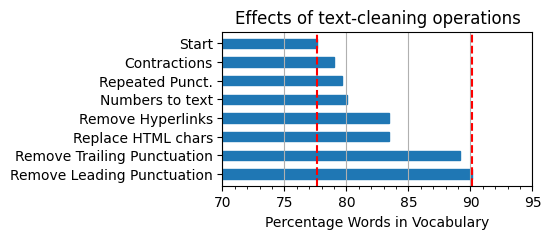

In [28]:
#
_dataLabels = [x[0] for x in reversed(IN_VOCAB_VALUES)]
_plotVals = [x[1] for x in reversed(IN_VOCAB_VALUES)]
_minVal, _maxVal = min(_plotVals), max(_plotVals)

_currKwargs = {"figSizeOnCreation":(4,2),
               "gridLinesShowX":True,
               "groupLabels":_dataLabels,
               "groupLabelRotation":0,
               "plotData1D":[_plotVals],
               "plotHorizontally":True,
               "plotVertLineColorStrs":['r'],
               "plotVertLinePositions":[_minVal, _maxVal],
               "plotVertLineStyleStrs":["--"],
               "showMinorTickMarkers":True,
               "titleStr":"Effects of text-cleaning operations",
               "xLabelStr":"Percentage Words in Vocabulary",
               "xLimit":[70,95]}
_barPlotter = ppl.BarPlotter(**_currKwargs)


#
_unused = _barPlotter.createPlot()

In [29]:
IN_VOCAB_VALUES

[['Start', 77.5870122773464],
 ['Contractions', 78.99319917449647],
 ['Repeated Punct.', 79.66544466601067],
 ['Numbers to text', 80.01637074513013],
 ['Remove Hyperlinks', 83.43543249203627],
 ['Replace HTML chars', 83.46991931897593],
 ['Remove Trailing Punctuation', 89.1672832447703],
 ['Remove Leading Punctuation', 90.14433228720718]]

**Look at the size of the vocabulary now its cleaned**

In [30]:
bowPipe = trainPipeHelp.AddBagOfWords()
bowPipe.fit(PROC_DATA)
vocabSize = len( bowPipe.vectorizer.vocabulary_.values() )
print("{} words in vocab using ngrams=1".format(vocabSize))

17035 words in vocab using ngrams=1


**Look at min counts for a given word given different vocab sizes**

This may help me gain some logical insight into sensible max vocabulary sizes; which is obviously a key hyperparameter

In [31]:
#Get the vectorizer 
_maxVocab = 5000
bowPipe = trainPipeHelp.AddBagOfWords(vectKwargs={"max_features":_maxVocab})
bowPipe.fit(PROC_DATA)
vectorizer = bowPipe.vectorizer

#Get the counts for each word + order them (so last array entry=least common word and its number of appearences)
countMatrix = vectorizer.transform(PROC_DATA["text"])
countFrame = pd.DataFrame(countMatrix.toarray(), columns=vectorizer.get_feature_names_out())
orderedCounts = countFrame.sum().sort_values(ascending=False)

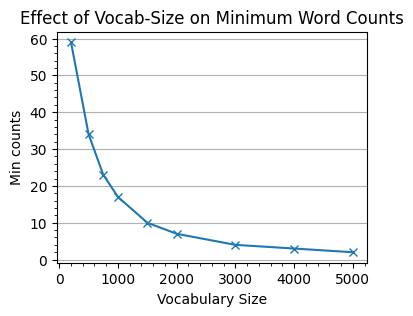

In [32]:
#Get the minimum counts for various vocab sizes
_vocabSizes = [200, 500, 750, 1000, 1500, 2000, 3000 , 4000, 5000]
_minCounts = [ orderedCounts[vsize-1] for vsize in _vocabSizes ]


#
_currKwargs = {"figSizeOnCreation":(4,3),
               "lineMarkerStyles":["x"],
               "gridLinesShowY":True,
               "plotData":[[ [_vSize, _minCount] for _vSize,_minCount in zip(_vocabSizes,_minCounts) ]],
               "showMinorTickMarkersX":True,
               "showMinorTickMarkersY":True,
               "titleStr": "Effect of Vocab-Size on Minimum Word Counts",
               "xLabelStr":"Vocabulary Size",
               "yLabelStr":"Min counts"
              }
minCountsPlotter = ppl.LinePlotter(**_currKwargs)
_unused = minCountsPlotter.createPlot()

**Effect of varying min/max df on vocabulary size**

In [33]:
def _getVocabSizeForVectorizerOpts(inpOpts):
    _bowPipe = trainPipeHelp.AddBagOfWords(vectKwargs=inpOpts).fit(PROC_DATA)
    return len(_bowPipe.vectorizer.vocabulary_)
    
_minDfVals = [0.0, 1e-3, 2e-3, 3e-3, 4e-3, 5e-3]
_maxDfVals = [1.0, 0.1, 0.05, 0.01, 0.005, 0.004, 0.003, 0.002, 0.001]

_vocabSizeVaryMinDf = [_getVocabSizeForVectorizerOpts({"min_df":x}) for x in _minDfVals]
_vocabSizeVaryMaxDf = [_getVocabSizeForVectorizerOpts({"max_df":x}) for x in _maxDfVals]


#
_minDfPlotVals = [ [xVal,yVal] for xVal,yVal in zip(_minDfVals,_vocabSizeVaryMinDf)  ]
_maxDfPlotVals = [ [xVal,yVal] for xVal,yVal in zip(_maxDfVals,_vocabSizeVaryMaxDf)  ]


/home/richard/Work/random/learning_ml/kaggle_comps/disaster_tweets_github/dis_tweets/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: AutoMinorLocator does not work with logarithmic scale
  func(*args, **kwargs)
/home/richard/Work/random/learning_ml/kaggle_comps/disaster_tweets_github/dis_tweets/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: AutoMinorLocator does not work with logarithmic scale
  fig.canvas.print_figure(bytes_io, **kw)


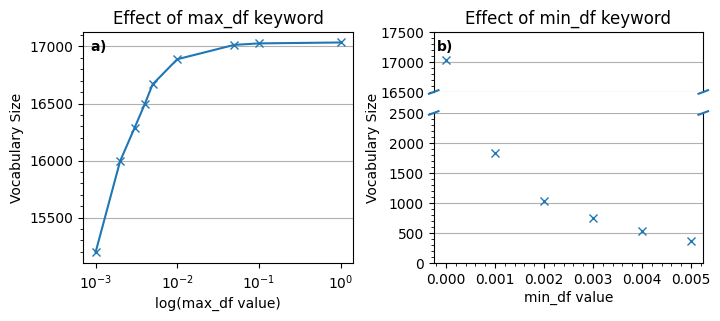

In [34]:
#Plotter for effect of min_df
_currKwargs = {"plotData":[_minDfPlotVals],
               "lineStyles":["None"],
               "titleStr":"Effect of min_df keyword",
               "xLabelStr":"min_df value",
               "yLabelStr":"Vocabulary Size"}
_minDfPlotter = minCountsPlotter.createFactory(**_currKwargs)

minDfSplitAxPlotter = ppl.SplitAxisPlotterCreator(plotter=_minDfPlotter,
                                                  xLabelOffset=-0.12,
                                                  yLabelOffset=-0.2,
                                                  yLimits=[ [0,2500] ,[16500,17500]])

#Plotter for effect of max_df
_currKwargs = {"axisScaleX":"log",
               "lineStyles":["-"],
               "plotData":[_maxDfPlotVals],
               "titleStr":"Effect of max_df keyword",
               "xLabelStr":"log(max_df value)"}
maxDfPlotter = _minDfPlotter.createFactory(**_currKwargs)


#Combine both into a multiplot
_currKwargs = {"annotateLabelStrings_useBoldedLowerAlphabetByDefault":True,
               "annotateLabelPosFract":[[1e-4,0.92], [1e-2,0.92]],
               "figWidthPerCol":4,
              "figHeightPerRow":3,
              "plotters":[maxDfPlotter,minDfSplitAxPlotter],
              "nColsGrid":2,
               "spacingHoz":0.3}
gridPlotter = ppl.RectMultiPlotter(**_currKwargs)
_unused = gridPlotter.createPlot()

**Visualize the intersection of relevant max_df/min_df values**

i.e. the vocabulary size for varying combinations

In [35]:
_maxDfVals = list(reversed([6e-3 ,7e-3, 8e-3, 9e-3, 1e-2]))
_minDfVals = list(reversed([1e-3, 2e-3, 3e-3, 4e-3]))

#
outArray = np.zeros( ( len(_maxDfVals),len(_minDfVals)  ) )
for rIdx,_maxDf in enumerate(_maxDfVals):
    for cIdx,_minDf in enumerate(_minDfVals):
        outArray[rIdx][cIdx] = _getVocabSizeForVectorizerOpts({"min_df":_minDf, "max_df":_maxDf})
        

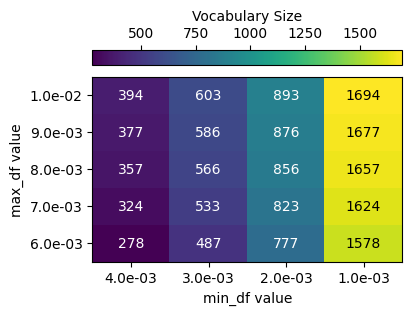

In [36]:
#
_currKwargs = {"annotateVals":True,
               "annotateValsStrFmt":"{:.0f}",
               "annotateValsTextColor":['white','black'],
               "colorBarLabel":"Vocabulary Size",
               "colorBarLocation":"top",
               "colorBarShow":True,
               "figSizeOnCreation":(4,3),
               "groupLabelsCols":["{:.1e}".format(x) for x in _minDfVals],
               "groupLabelsRows":["{:.1e}".format(x) for x in _maxDfVals],
               "plotData":outArray,
               "xLabelStr":"min_df value",
               "yLabelStr":"max_df value"
              }
heatPlotter = ppl.DiscreteHeatMapPlotter(**_currKwargs)
_unused = heatPlotter.createPlot()

**Look at vocabulary sizes for ngrams=(1,2)**

Meaning pairs of words can appear

In [37]:
def _getVocabSizeForVectorizerOpts(inpOpts):
    _bowPipe = trainPipeHelp.AddBagOfWords(vectKwargs=inpOpts).fit(PROC_DATA)
    return len(_bowPipe.vectorizer.vocabulary_)
    
_minDfVals = [0.0, 1e-3, 2e-3, 3e-3, 4e-3, 5e-3]
_maxDfVals = [1.0, 0.1, 0.05, 0.01, 0.005, 0.004, 0.003, 0.002, 0.001]

_vocabSizeVaryMinDf = [_getVocabSizeForVectorizerOpts({"min_df":x, "ngram_range":(1,2)}) for x in _minDfVals]
_vocabSizeVaryMaxDf = [_getVocabSizeForVectorizerOpts({"max_df":x, "ngram_range":(1,2)}) for x in _maxDfVals]

#
_minDfPlotVals = [ [xVal,yVal] for xVal,yVal in zip(_minDfVals,_vocabSizeVaryMinDf)  ]
_maxDfPlotVals = [ [xVal,yVal] for xVal,yVal in zip(_maxDfVals,_vocabSizeVaryMaxDf)  ]


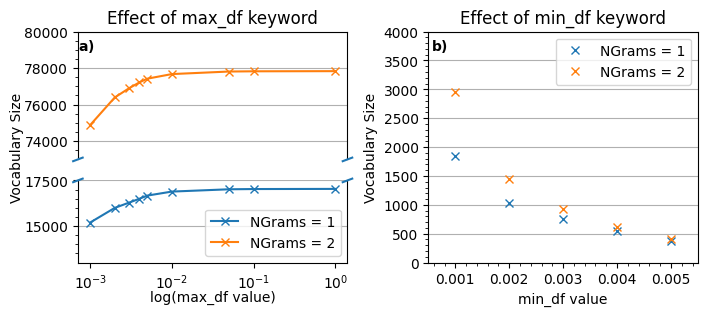

In [38]:
#Plotter for effect of min_df
_currKwargs = {"dataLabels":["NGrams = 1", "NGrams = 2"],
               "plotData":_minDfPlotter.opts.plotData.value + [_minDfPlotVals],
               "showLegend":True,
               "xLimit":[5e-4,5.5e-3],
               "yLimit":[0,4000]}
_newMinDfPlotter = _minDfPlotter.createFactory(**_currKwargs)

#
_currKwargs = {"dataLabels":["NGrams = 1", "NGrams = 2"],
               "plotData":maxDfPlotter.opts.plotData.value + [_maxDfPlotVals],
              "showLegend":True}
maxDfPlotterB = maxDfPlotter.createFactory(**_currKwargs)

#
_currKwargs = {"plotter":maxDfPlotterB,
               "xLabelOffset":-0.12,
               "yLabelOffset":-0.2,
               "yLimits":[ [1.3e4,1.75e4], [7.3e4,8e4] ]}
splitMaxDfPlotter = ppl.SplitAxisPlotterCreator(**_currKwargs)

#
_unused = gridPlotter.createPlot(plotters=[splitMaxDfPlotter,_newMinDfPlotter])

Look at the combined min/max df vocab sizes for NGrams=2 

This looks pretty much the same as the NGrams=1, just slightly large vocab size for each pair of values

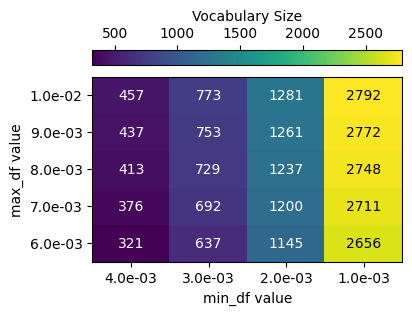

In [39]:
_maxDfVals = list(reversed([6e-3 ,7e-3, 8e-3, 9e-3, 1e-2]))
_minDfVals = list(reversed([1e-3, 2e-3, 3e-3, 4e-3]))

#
outArray = np.zeros( ( len(_maxDfVals),len(_minDfVals)  ) )
for rIdx,_maxDf in enumerate(_maxDfVals):
    for cIdx,_minDf in enumerate(_minDfVals):
        _currKwargs = {"min_df":_minDf, "max_df":_maxDf, "ngram_range":(1,2)}
        outArray[rIdx][cIdx] = _getVocabSizeForVectorizerOpts( _currKwargs )
    
_unused = heatPlotter.createPlot(plotData=outArray)

**Print a few transformed tweets out**

In [40]:
[x for x in PROC_DATA["text"][:50]]

['our deeds are the reason of this #earthquake may allah forgive us all',
 'forest fire near la ronge sask . canada',
 "all residents asked to ' shelter in place ' are being notified by officers . no other evacuation or shelter in place orders are expected",
 '13 ,000 people receive #wildfires evacuation orders in california ',
 'just got sent this photo from ruby #alaska as smoke from #wildfires pours into a school ',
 '#rockyfire update => california hwy . 20 closed in both directions due to lake county fire - #cafire #wildfires',
 '#flood #disaster heavy rain causes flash flooding of streets in manitou , colorado springs areas',
 'i am on top of the hill and i can see a fire in the woods .',
 'there is an emergency evacuation happening now in the building across the street',
 'i am afraid that the tornado is coming to our area .',
 'three people died from the heat wave so far',
 'haha south tampa is getting flooded hah- wait a second i live in south tampa what am i gonna do what am 